In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math

### Données


In [15]:
df_chauffage = pd.read_csv('data/df_chauffage.csv', delimiter = ';')
df_chauffage

,Compacite,Superficie,SurfaceMur,SurfaceToit,Hauteur,Orientation,SurfaceVitree,RepartitionVitres,Chauffage
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84
...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48


In [16]:
# Séparation des données et de la valeur a approximer
data = df_chauffage.drop('Chauffage', axis=1)
y = df_chauffage['Chauffage']

### Sélection des features

Dans un problème de régression, la corrélation des variables peut avoir un effet sur l'éfficacité des modèles. Les variables sont censées être indépendantes. On va donc analyser les variables pour voir s'il on peut en supprimer du modèle.
On commence par afficher la matrice de corrélation des variables.

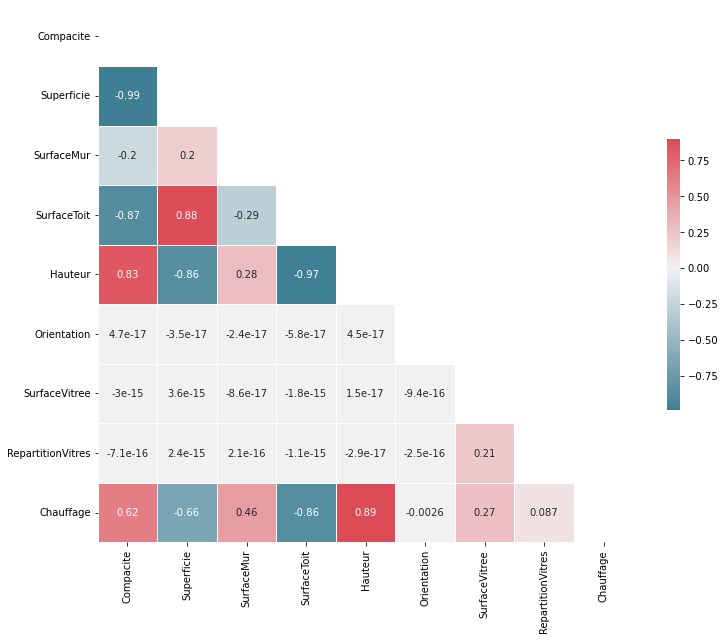

In [17]:
corr = df_chauffage.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask,cmap=cmap, vmax=.9, center=0, square=True, linewidths=.5, annot=True,cbar_kws={"shrink": .5})
plt.show()

On remarque que la variable **Superficie** est très corrélé avec **Compacite** ainsi que la variable **Hauteur** est corrélé à la variable **Surface Toit**.
Pour pouvoir prendre une décision, on va regarder l'impact de chaque variable à l'aide d'une régression avec un **Random Forest**.

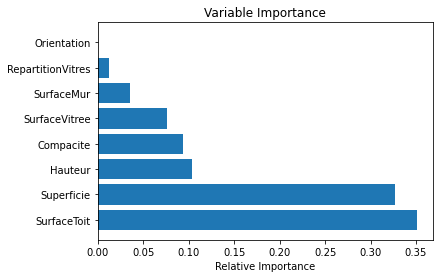

In [23]:
rf_model = RandomForestRegressor(random_state=123)
rf_model.fit(data, y)

std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],axis=0)
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
features = df_chauffage.columns
padding = np.arange(data.size/len(data))
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()


On remarque les variables **Surface Toit**, **Superficie** et **Hauteur** sont les variables avec le plus d'impact. On va donc les garder ces variables et supprimer **Compacite**

In [62]:
df_chauffage = df_chauffage.drop(columns='Compacite')

In [6]:
#Mélange des lignes et séparation des classes des données
df_chauffage = df_chauffage.sample(frac=1).reset_index(drop=True)

#Division entre données d'apprentissage (70%) et de test (30%) 
X_train, X_test, Y_train, Y_test = train_test_split(data, y, test_size=0.3)

data

,Compacite,Superficie,SurfaceMur,SurfaceToit,Hauteur,Orientation,SurfaceVitree,RepartitionVitres
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0
...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5


### Modèles de Régression

Maintenant que nous avons les données nettoyées et séparées entre set d'entrainement et de test, nous pouvons essayer plusieurs modèles de régression.

Dans le cas d'une régression, il est presque impossible de trouver la valeur exacte. On va donc plutôt regarder à quel point la valeur trouvée est proche de la valeur original.
Dans notre cas, nous allons utiliser  :
- **le Coefficient de détermination** (r²)qui mesure la qualité de la régression
- **l'Erreur quadratique moyenne** (MSE) qui mesure la précision de la régression

### Regression Linéaire

In [25]:
def testLinearRegression(model, data, y, info):
    y_predict = model.predict(data)
    rmse = (np.sqrt(mean_squared_error(y, y_predict)))
    r2 = r2_score(y, y_predict)

    print('La performance du modèle {}'.format(info))
    print('--------------------------------------')
    print('L\'erreur quadratique moyenne est {}'.format(rmse))
    print('le score R2 est {}'.format(r2))
    print('\n')
    
    f, ax1 = plt.subplots(1, 1, sharey=True)
    ax1.plot(range(0,len(data)),y.iloc[:],'o',color='red',label = 'Actual Values')
    ax1.plot(range(0,len(data)),y_predict[:],'X',color='yellow',label = 'Predicted Values')
    ax1.set_xlabel('Cas {}'.format(info))
    ax1.set_ylabel('Chauffage')
    ax1.legend(loc = 'upper right')
    
    plt.show()

La performance du modèle d'entrainement
--------------------------------------
L'erreur quadratique moyenne est 3.0387808359750585
le score R2 est 0.9082440045886354




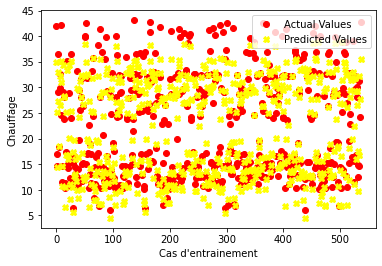

La performance du modèle de test
--------------------------------------
L'erreur quadratique moyenne est 2.9971707472274116
le score R2 est 0.9136069815689587




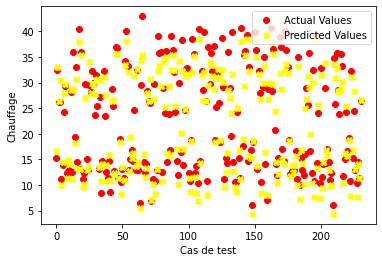

In [66]:
reg = LinearRegression()
model = reg.fit(X_train, Y_train)
 
testLinearRegression(model, X_train, Y_train, 'd\'entrainement')
testLinearRegression(model, X_test, Y_test, 'de test')

### Régression polynomiale

Nous allons aussi tester la régression polynomiale pour voir si un polynome approxime mieux les données. Nous cherchons en premier à trouver le degré du polynome qui maximise le résultat pour le jeu de test.

La performance du modèle d'entrainement
--------------------------------------
L'erreur quadratique moyenne est 0.30484383427184963
le score R2 est 0.9991097594553363




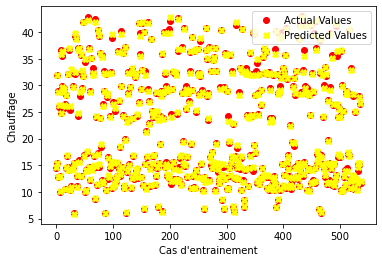

La performance du modèle de test
--------------------------------------
L'erreur quadratique moyenne est 0.17776122795545074
le score R2 est 0.9996687198211563




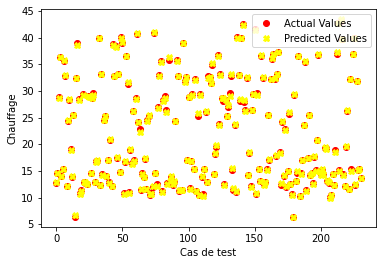

In [58]:
erreur_test = float('inf')
score_test = 0
i_test = 0

model = LinearRegression()

for i in range(1,10):
    polynomial_features= PolynomialFeatures(degree=i)
    
    data_poly_test = polynomial_features.fit_transform(X_test)
    model.fit(data_poly_test, Y_test)
    
    y_predict = model.predict(data_poly_test)
    rmse = (np.sqrt(mean_squared_error(Y_test, y_predict)))
    r2 = r2_score(Y_test, y_predict)
    
    if(rmse < erreur_test and r2 > score_test ):
        erreur_test = rmse
        score_test = r2
        i_test = i
        

polynomial_features= PolynomialFeatures(degree=i_test)
    
data_poly_train = polynomial_features.fit_transform(X_train)
model.fit(data_poly_train, Y_train)
testLinearRegression(model, data_poly_train, Y_train, 'd\'entrainement')

data_poly_test = polynomial_features.fit_transform(X_test)
model.fit(data_poly_test, Y_test)
testLinearRegression(model, data_poly_test, Y_test, 'de test')

### Régression par Arbre de décision

La performance du modèle d'entrainement
--------------------------------------
L'erreur quadratique moyenne est 1.327711439017662e-16
le score R2 est 1.0




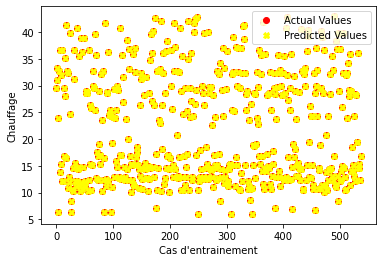

La performance du modèle de test
--------------------------------------
L'erreur quadratique moyenne est 0.5538167449734497
le score R2 est 0.9969572637123045




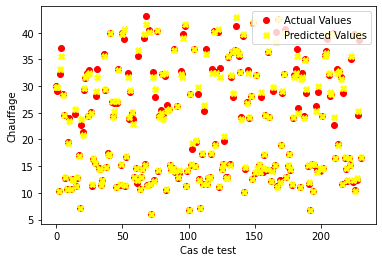

In [21]:
dt_model = DecisionTreeRegressor(random_state=123)
model = dt_model.fit(X_train, Y_train)

testLinearRegression(model, X_train, Y_train, 'd\'entrainement')
testLinearRegression(model, X_test, Y_test, 'de test')

### Régression par Random Forest

La performance du modèle d'entrainement
--------------------------------------
L'erreur quadratique moyenne est 0.1837206361341245
le score R2 est 0.9996600128604265




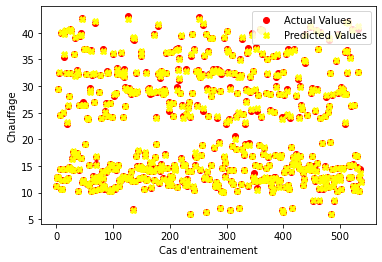

La performance du modèle de test
--------------------------------------
L'erreur quadratique moyenne est 0.5100876167841552
le score R2 est 0.9975554838458766




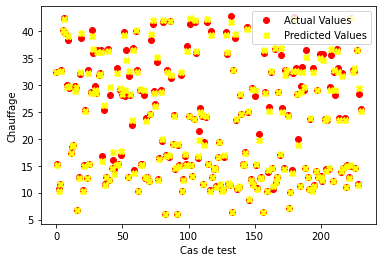

In [26]:
rf_model = RandomForestRegressor(random_state=123)
model = rf_model.fit(X_train, Y_train)

testLinearRegression(model, X_train, Y_train, 'd\'entrainement')
testLinearRegression(model, X_test, Y_test, 'de test')

### Perceptron Multi-couche

La performance du modèle d'entrainement
--------------------------------------
L'erreur quadratique moyenne est 0.2598288158147927
le score R2 est 0.9993199807034188




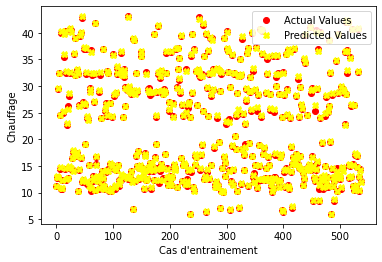

La performance du modèle de test
--------------------------------------
L'erreur quadratique moyenne est 1.5203234743571568
le score R2 est 0.9782842240054451




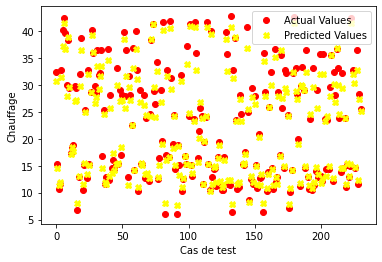

In [39]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

MLP = MLPRegressor(hidden_layer_sizes=(300,250,200,150,100,50),activation = 'relu',solver='adam',alpha = 0.00001, batch_size='auto', max_iter=300000, beta_1 = 0.9)
model = MLP.fit(X_train, Y_train)

testLinearRegression(model, X_train, Y_train, 'd\'entrainement')
testLinearRegression(model, X_test, Y_test, 'de test')

#### Conclusion :
Des différents modèles que nous avons pu essayer, la régression polynomiale est le modèle avec lequel nous avons eu les meilleurs résultats.